In [233]:
import numpy as np
import numba as nb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import quantecon
import time
from interpolation.splines import UCGrid, CGrid, nodes
from interpolation.splines import eval_linear
from quantecon.optimize import brent_max
from quantecon.optimize import nelder_mead
from scipy.interpolate import interp1d

In [234]:
T=36         # Number of periods, age 50-95,everyone dies at age 96
β=0.98       # Discount factor
gamma=1.5    # Utility parameter-coefficient of relative risk aversion
nu=0.533     # Utility parameter-consumption weight
#L=3900       # Total time endowment
L=4400       # Total time endowment
ϕ_p=1000     # Fixed cost of work
λ=1.835766   ## Average tax rate (HSV Taxation)
τ=0.062668   ## Progressivity of the tax system (HSV Taxation)
θ=1.7
kappa=5e5
Cmin=1e-5    # Minimum consumption
tol=1e-10   
eret=62      # Early retirement age
nret=65      # Normal retirement age

r=0.02          # Risk-free return rate
r_pen = 0.04    # pension plan mean rate of return
ϕ_1   = 0.066   # pension contribution rate( from laborincome)
"""""""""""""""""""""""""""""""""""""""""""""
Required Minimum Distribution rules since age 70
"""""""""""""""""""""""""""""""""""""""""""""
#Website: https://www.irs.gov/pub/irs-tege/uniform_rmd_wksht.pdf
# From age 70 to 95
ϕ_2   = np.ones(T+1)
ϕ_2[20]=27.4   #age 70
ϕ_2[21]=26.5
ϕ_2[22]=25.6
ϕ_2[23]=24.7
ϕ_2[24]=23.8   #age 74

ϕ_2[25]=22.9   #age 75
ϕ_2[26]=22.0
ϕ_2[27]=21.2
ϕ_2[28]=20.3
ϕ_2[29]=19.5  #age 79

ϕ_2[30]=18.7   #age 80
ϕ_2[31]=17.9
ϕ_2[32]=17.1
ϕ_2[33]=16.3
ϕ_2[34]=15.5   #age 84

ϕ_2[35]=14.8   #age 85
# ϕ_2[36]=14.1
# ϕ_2[37]=13.4
# ϕ_2[38]=12.7
# ϕ_2[39]=12.0   #age 89

# ϕ_2[40]=11.4   #age 90
# ϕ_2[41]=10.8
# ϕ_2[42]=10.2
# ϕ_2[43]=9.6
# ϕ_2[44]=9.1   #age 94
# ϕ_2[45]=8.6   #age 95
# ϕ_2[46]=1e-10     #age 96
ϕ_2=1/ϕ_2  # RMD percentage
"""""""""""""""""""""""""""""""""""""""
wage shock process
AR_t=rho*AR_t-1+ϵ_t, ϵ_t ~N(0,sigma^2)
"""""""""""""""""""""""""""""""""""""""
#rho=0.935
#sigma2=0.016
ρ=0.977               ## ρ of the AR(1) process
σ=np.sqrt(0.0141)     ## σ Standard deviation of the shocks
"""""""""""""""
  Grid points
"""""""""""""""
Apoints=30      # Asset grid points
Epoints=5       # Wage shock grid points
AIMEpoints=10   # AIME grid points
Penpoints=15      # Pension grid points
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Social Security bent points for 2004
Link here: https://www.ssa.gov/oact/cola/bendpoints.html
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
bk1=612*12       # Bent point 1
bk2=3689*12      # Bent point 2
mpr1= 0.9        # Percentage on [0, bk1]
mpr2=0.32        # Percentage on [bk1, bk2]
mpr3=0.15        # Percentage on [bk2, bk3]
pia1=0.9*bk1                   # 0.9*bk1   
pia2=0.9*bk1+(bk2-bk1)*.32     # 0.9*bk1 + 0.32*(bk2-bk1)
#AIMEmax=87900    # 2004 rule, Website: https://www.ssa.gov/OACT/COLA/cbb.html

#Load in the deterministic wage profile from DJ
#wage1=pd.read_csv("/Users/yanzhao/Downloads/SIPP data/2018 Panel/data from DJ/wage_men_HRS.csv")
wage1=pd.read_csv("/Users/yanzhao/Downloads/SIPP data/2018 Panel/data from DJ/wage_profile_men.csv")
surv1=pd.read_csv("/Users/yanzhao/Downloads/SIPP data/2018 Panel/data from DJ/survivial_men_HRS.csv")

"""""""""""""""""""""""""""""""""""""""
Generate wage and death rate process
"""""""""""""""""""""""""""""""""""""""
#wage1['wage process']=0.5*(wage1['bad']+wage1['good'])
surv1['surv_rate']=0.5*(surv1['bad']+surv1['good'])

wages=wage1['good'].values
surv=surv1['surv_rate'].values

#Survival probability 
S=np.zeros(T+1)
S[0:-1]=1-surv
S[-1]=0   #everyone dies at last period, age 96

"""""""""""""""""""""""""""""""""""""""""""""""
Create grids for AIME, wage, Assets and pension
"""""""""""""""""""""""""""""""""""""""""""""""
@nb.jit(nopython=True)
def createFrenchGrid(gridPoints,gridBreak,min1,max1,breakpoint):
    first_grid=np.linspace(min1,breakpoint,gridBreak)
    first_grid=first_grid[0:-1]
    second_grid=np.linspace(breakpoint,max1,gridPoints-gridBreak+1)
    aGrid=np.hstack((first_grid,second_grid))
    return aGrid

@nb.jit(nopython=True)
def computeAfterTaxIncome(income):
    income = λ*(income)**(1-τ)
    return income

@nb.jit(nopython=True)
def computeAIME(aim,income,age):
    if age<60:
        nextAIME=aim+(income)*1/35
    else:
        nextAIME=aim+max(0,income-aim)*1/35
    if nextAIME>aimemax:
        nextAIME=aimemax
    return nextAIME

@nb.jit(nopython=True)
def computePIA(value):
    if value<bk1:
        PIA=mpr1*value
    elif value<bk2:
        PIA=pia1 + mpr2*(value - bk1)
    else:
        PIA = pia2 + mpr3*(value - bk2)
    return PIA

aimemax = 87900
@nb.jit(nopython=True)
def findAIME(PIA):
    if PIA/mpr1<bk1:
        nextAIME=PIA/mpr1
    elif bk1+(PIA-pia1)/mpr2 < bk2:
        nextAIME= bk1 + (PIA - pia1)/mpr2
    else:
        nextAIME= bk2 + (PIA - pia2)/mpr3
    if nextAIME>aimemax:
        nextAIME=aimemax
    return nextAIME

@nb.jit(nopython=True)
def bequests(money):
    beq=θ*(money+kappa)**((1-gamma)*nu)/(1-gamma)
    return beq

# AIME grids
AIMEmean = 38804.80
AIMEsd = 13621.011
AIMEmin = AIMEmean - 1.5*AIMEsd
AIMEmax = AIMEmean + 2*AIMEsd
AIMEbreak = AIMEmean
aimeGrid = createFrenchGrid(10, 4, AIMEmin, AIMEmax, AIMEmean)

# Wage grids
mc1=quantecon.markov.approximation.rouwenhorst(Epoints,0, σ,ρ)
#mc1=quantecon.markov.approximation.tauchen(0.935, 0.016, b=0, m=3, n=3)
epsGrid=np.exp(mc1.state_values)  #Grid Size (5,)

#print(np.exp(mc1.state_values))
#print(mc1.P)

# Asset grids
aGrid=createFrenchGrid(30,15,0,600000,100000)

# Pension Grids
penGrid=createFrenchGrid(15,7,5000,400000,100000)
# 2004 tax brackets parameters
# ati= [6435.   25050.   56025.  111033.  226507.5]
#----------------------------------------------------------------------
#  pre-tax income(Y)       Post-tax income(Yτ)            Marginal tax rate
#     0-tbk[0]                 Y*(1-mtr[0])                    mtr[0]
#   tbk[0] to tbk[1]     ati[0]+(Y-tbk[0])*(1-mtr[1])          mtr[1]
#   tbk[1] to tbk[2]     ati[1]+(Y-tbk[1])*(1-mtr[2])          mtr[2]
#   tbk[2] to tbk[3]     ati[2]+(Y-tbk[2])*(1-mtr[3])          mtr[3]
#   tbk[3] to tbk[4]     ati[3]+(Y-tbk[3])*(1-mtr[4])          mtr[4]
#----------------------------------------------------------------------
#Tax brackets bend points
# tbk=np.zeros(5)
# tbk[0]=7150
# tbk[1]=29050
# tbk[2]=70350
# tbk[3]=146750
# tbk[4]=319100

#Marginal tax rate for each brackets
# mtr=np.zeros(6)
# mtr[0]=0.1
# mtr[1]=0.15
# mtr[2]=0.25
# mtr[3]=0.28
# mtr[4]=0.33
# mtr[5]=0.35

# ati=np.zeros(5)
# ati[0]=tbk[0]*(1-mtr[0])
# ati[1]=ati[0]+(tbk[1]-tbk[0])*(1-mtr[1])
# ati[2]=ati[1]+(tbk[2]-tbk[1])*(1-mtr[2])
# ati[3]=ati[2]+(tbk[3]-tbk[2])*(1-mtr[3])
# ati[4]=ati[3]+(tbk[4]-tbk[3])*(1-mtr[4])


#Define all sorts of functions here
# @nb.jit(nopython=True)
# def computeAfterTaxIncome(labor_income,assets,pen_withdraw):
#     """""""""""""""""""""""""""""""""""""""""""""""""""
#     inputs are labor income, assets and pension withdrawal
#     """""""""""""""""""""""""""""""""""""""""""""""""""
#     Y= (1-ϕ_1)*labor_income + r*assets + pen_withdraw
#     if Y < tbk[0]:
#         Yτ = (1-mtr[0])*Y
#     elif Y < tbk[1]:
#         Yτ = ati[0]+(1-mtr[1])*(Y-tbk[0])
#     elif Y < tbk[2]:
#         Yτ = ati[1]+(1-mtr[2])*(Y-tbk[1])
#     elif Y < tbk[3]:
#         Yτ = ati[2]+(1-mtr[3])*(Y-tbk[2])
#     elif Y < tbk[4]:
#         Yτ = ati[3]+(1-mtr[4])*(Y-tbk[3])
#     else:
#         Yτ = ati[4]+(1-mtr[5])*(Y-tbk[4])
#     return Yτ

####command+/ to un-comment the block!
####command+/ to un-comment the block!
####command+/ to un-comment the block!

# @nb.jit(nopython=True)
# def createMinMaxAssets(maxInc,Astart):
#     maxA=np.zeros(T+1)
#     maxA[0]=Astart
#     for i in range(1,T-10):
#         maxA[i]= maxA[i-1] + computeAfterTaxIncome(maxInc+r*maxA[i-1])
#         #maxA[i]= maxA[i-1] + computeTax(maxA[i-1]*r + maxInc)
#     return maxA
# maA=createMinMaxAssets(67,1e5)

# @nb.jit(nopython=True)
# def createMaxPension(maxInc,pen_start):
#     maxPen=np.zeros(T+1)
#     maxPen[0]=pen_start
#     for i in range(1,T-10):
#         maxPen[i]= maxPen[i-1] + ϕ_1*maxInc
#     return maxPen
# pen_start=88141.97
# maxPen=createMaxPension(max(wages)*epsGrid[4]*(L-ϕ_p),pen_start)

# -------------------------------------------- #
#          Social security calculations        #
# -------------------------------------------- #

#early retirement penalty factors
#In the case of early retirement, a benefit is reduced 5/9 of one percent for each month before 
#normal retirement age,up to 36 months. [(5/9)*0.01*months]
#If the number of months exceeds 36, then the benefit is further reduced 5/12 of one percent per month.

# Contribution and benefit base for 2004 from here
# Link: https://www.ssa.gov/OACT/COLA/cbb.html
eretadj = np.array([(5/9)*0.01*36, (5/9)*0.01*24, (5/9)*0.01*12])
litcred = np.array([0.06, 0.12, 0.18, 0.24,0.30])
#litcred = np.array([0.03, 0.06, 0.09, 0.12,0.15])
eretadj=1-eretadj
litcred=1+litcred
early=np.zeros(3)
late=np.zeros(5)
early[0]=eretadj[0]/eretadj[1]
early[1]=eretadj[1]/eretadj[2]
early[2]=eretadj[2]/1
late[0]=litcred[0]-1
late[1]=litcred[1]/litcred[0] -1
late[2]=litcred[2]/litcred[1] -1
late[3]=litcred[3]/litcred[2] -1
late[4]=litcred[4]/litcred[3] -1

@nb.jit(nopython=True)
def computeSSB(aim,age):
    eretadj = np.array([(5/9)*0.01*36, (5/9)*0.01*24, (5/9)*0.01*12])
    litcred = np.array([0.06, 0.12, 0.18, 0.24,0.3])
    PIA=computePIA(aim)
    ## Penalty factors for early retirement
    if age==62:
        SSB=PIA*(1-eretadj[0])
    elif age==63:
        SSB=PIA*(1-eretadj[1])
    elif age==64:
        SSB=PIA*(1-eretadj[2])
    elif age>=65:
        SSB=PIA
    else:
        SSB=0
    return SSB
#---------------------------------------------------------------------------------------
# Choice variables: next_period_asset, hours of labor, SS application, pension withdrawal
# State  variables: pension_wealth, asset, AIME, wage, SS application status
#---------------------------------------------------------------------------------------

##########################################################################################################
##########################################################################################################
##########################################################################################################
##########################################################################################################


@nb.jit(nopython=True)
def valuefun_0h0pen(aPrime,h,pen_withdraw,B,bt,asset,aim,pension,w,surv,EV1,age,grid1):
    """""""""""""""""""""""""""""""""""""""""""""
    Choice variable x: aPrime, hours,pension_withdrawal
    State  variable  : asset, AIME, pension, wage, bt(last period SS application)
    """""""""""""""""""""""""""""""""""""""""""""
    
    
    SSB=computeSSB(aim,age)      #Calculate the social security benefits
    laborIncome=(1-ϕ_1)*w*h
    afterTaxIncome = computeAfterTaxIncome(laborIncome+r*asset+pen_withdraw)   #HSV tax function
    
    c = asset + afterTaxIncome + B*SSB - aPrime  #get consumption
    
    if c<=0:
        uc=-1e15
    else:
        ℓ=L-h-ϕ_p*(h>0)
        
        """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        Adjust next period pension based on age and pension_withdrawal
        """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        nextPEN=0.0
        if age<60:
            nextPEN=(1+r_pen)*(pension+ϕ_1*w*h)
        elif age>=60 and age<70:
            nextPEN=(1+r_pen)*(pension+ϕ_1*w*h-pen_withdraw)
        elif age>=70:
            nextPEN=(1+r_pen)*(pension+ϕ_1*w*h-pen_withdraw)
        else:
            raise ValueError("Something wrong with pension in the valuefunction")

        #Calculate next period AIME ajusted for laborincome this period
        aim=computeAIME(aim,laborIncome, age)  
        """""""""""""""""""""""""""""""""""""""""""""
        Adjust next period AIME based on bt,B and age
        """""""""""""""""""""""""""""""""""""""""""""
        nextAIME=0.0
        if bt==0:
            #if didnt apply last year
            if B==0:
                if age<65:
                    nextAIME=aim*2/2
                    #nextAIME=copy.deepcopy(aim)
                elif age==65:
                    nextPIA=computePIA(aim)*(1+late[0])
                    nextAIME=findAIME(nextPIA)
                elif age==66:
                    nextPIA=computePIA(aim)*(1+late[1])
                    nextAIME=findAIME(nextPIA)
                elif age==67:
                    nextPIA=computePIA(aim)*(1+late[2])
                    nextAIME=findAIME(nextPIA)          
                elif age==68:
                    nextPIA=computePIA(aim)*(1+late[3])
                    nextAIME=findAIME(nextPIA)
                elif age==69:
                    nextPIA=computePIA(aim)*(1+late[4])
                    nextAIME=findAIME(nextPIA)
                else:
                    raise ValueError("Agents older than 70 are still not claiming SS benefit")

            if B==1:
                if age<62:
                    raise ValueError("Kids younger than 62 can't claim SS benefit")
                if age==62:
                    nextPIA=computePIA(aim)*(early[0])
                    nextAIME=findAIME(nextPIA)
                if age==63:
                    nextPIA=computePIA(aim)*(early[1])
                    nextAIME=findAIME(nextPIA)
                if age==64:
                    nextPIA=computePIA(aim)*(early[2])
                    nextAIME=findAIME(nextPIA)
                if age>=65:
                    nextAIME=aim*2/2
                    #nextAIME=copy.deepcopy(aim)
        elif bt==1:
                #applied SSB last year, then B=1 for sure
                if age<=62:
                    raise ValueError("Agents applied SSB last year before age 62")
                if age==63:
                    nextPIA=computePIA(aim)*(early[1])
                    nextAIME=findAIME(nextPIA)
                if age==64:
                    nextPIA=computePIA(aim)*(early[2])
                    nextAIME=findAIME(nextPIA)
                if age>=65:
                    nextAIME=aim*2/2
                    #nextAIME=copy.deepcopy(aim)
        else:
            raise ValueError("bt is neither 0 or 1")
        #if age==77:
        #    print("pension,wage,hours,withdraw are",pension,w,h,pen_withdraw)
        #    print(nextPEN)
        if nextPEN>penGrid[-1]:
            nextPEN=penGrid[-1]
        if nextPEN>penGrid[-1]:
            raise ValueError("nextPen tooo big")
            
        point1=np.array([aPrime,nextAIME,nextPEN])
        EV_value=eval_linear(grid1,EV1,point1)
            
        uc=( ( (c**nu)*(ℓ**(1-nu)) )**(1-gamma)  )/(1-gamma) \
                                            + β*surv*EV_value + β*(1-surv)*bequests(aPrime+nextPEN)      
    return uc





@nb.jit(nopython=True)
def valuefun_0h(x,h,B,bt,asset,aim,pension,w,surv,EV1,age,grid1):
    aPrime,pen_withdraw=x
    """""""""""""""""""""""""""""""""""""""""""""
    Choice variable x: aPrime, hours,pension_withdrawal
    State  variable  : asset, AIME, pension, wage, bt(last period SS application)
    """""""""""""""""""""""""""""""""""""""""""""
    
    
    SSB=computeSSB(aim,age)      #Calculate the social security benefits
    laborIncome=(1-ϕ_1)*w*h
    afterTaxIncome = computeAfterTaxIncome(laborIncome+r*asset+pen_withdraw)   #HSV tax function
    
    c = asset + afterTaxIncome + B*SSB - aPrime  #get consumption
    
    if c<=0:
        uc=-1e15
    else:
        ℓ=L-h-ϕ_p*(h>0)
        
        """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        Adjust next period pension based on age and pension_withdrawal
        """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        nextPEN=0.0
        if age<60:
            nextPEN=(1+r_pen)*(pension+ϕ_1*w*h)
        elif age>=60 and age<70:
            nextPEN=(1+r_pen)*(pension+ϕ_1*w*h-pen_withdraw)
        elif age>=70:
            nextPEN=(1+r_pen)*(pension+ϕ_1*w*h-pen_withdraw)
        else:
            raise ValueError("Something wrong with pension in the valuefunction")

        #Calculate next period AIME ajusted for laborincome this period
        aim=computeAIME(aim,laborIncome, age)  
        """""""""""""""""""""""""""""""""""""""""""""
        Adjust next period AIME based on bt,B and age
        """""""""""""""""""""""""""""""""""""""""""""
        nextAIME=0.0
        if bt==0:
            #if didnt apply last year
            if B==0:
                if age<65:
                    nextAIME=aim*2/2
                    #nextAIME=copy.deepcopy(aim)
                elif age==65:
                    nextPIA=computePIA(aim)*(1+late[0])
                    nextAIME=findAIME(nextPIA)
                elif age==66:
                    nextPIA=computePIA(aim)*(1+late[1])
                    nextAIME=findAIME(nextPIA)
                elif age==67:
                    nextPIA=computePIA(aim)*(1+late[2])
                    nextAIME=findAIME(nextPIA)          
                elif age==68:
                    nextPIA=computePIA(aim)*(1+late[3])
                    nextAIME=findAIME(nextPIA)
                elif age==69:
                    nextPIA=computePIA(aim)*(1+late[4])
                    nextAIME=findAIME(nextPIA)
                else:
                    raise ValueError("Agents older than 70 are still not claiming SS benefit")

            if B==1:
                if age<62:
                    raise ValueError("Kids younger than 62 can't claim SS benefit")
                if age==62:
                    nextPIA=computePIA(aim)*(early[0])
                    nextAIME=findAIME(nextPIA)
                if age==63:
                    nextPIA=computePIA(aim)*(early[1])
                    nextAIME=findAIME(nextPIA)
                if age==64:
                    nextPIA=computePIA(aim)*(early[2])
                    nextAIME=findAIME(nextPIA)
                if age>=65:
                    nextAIME=aim*2/2
                    #nextAIME=copy.deepcopy(aim)
        elif bt==1:
                #applied SSB last year, then B=1 for sure
                if age<=62:
                    raise ValueError("Agents applied SSB last year before age 62")
                if age==63:
                    nextPIA=computePIA(aim)*(early[1])
                    nextAIME=findAIME(nextPIA)
                if age==64:
                    nextPIA=computePIA(aim)*(early[2])
                    nextAIME=findAIME(nextPIA)
                if age>=65:
                    nextAIME=aim*2/2
                    #nextAIME=copy.deepcopy(aim)
        else:
            raise ValueError("bt is neither 0 or 1")
        #if age==77:
        #    print("pension,wage,hours,withdraw are",pension,w,h,pen_withdraw)
        #    print(nextPEN)
        if nextPEN>penGrid[-1]:
            nextPEN=penGrid[-1]
        if nextPEN>penGrid[-1]:
            raise ValueError("nextPen tooo big")
            
        point1=np.array([aPrime,nextAIME,nextPEN])
        EV_value=eval_linear(grid1,EV1,point1)
            
        uc=( ( (c**nu)*(ℓ**(1-nu)) )**(1-gamma)  )/(1-gamma) \
                                            + β*surv*EV_value + β*(1-surv)*bequests(aPrime+nextPEN)      
    return uc

##########################################################################################################
##########################################################################################################
##########################################################################################################
##########################################################################################################

@nb.jit(nopython=True)
def valuefun_0pen(x,pen_withdraw,B,bt,asset,aim,pension,w,surv,EV1,age,grid1):
    aPrime,h=x
    """""""""""""""""""""""""""""""""""""""""""""
    Choice variable x: aPrime, hours,pension_withdrawal
    State  variable  : asset, AIME, pension, wage, bt(last period SS application)
    """""""""""""""""""""""""""""""""""""""""""""
    
    
    SSB=computeSSB(aim,age)      #Calculate the social security benefits
    laborIncome=(1-ϕ_1)*w*h
    afterTaxIncome = computeAfterTaxIncome(laborIncome+r*asset+pen_withdraw)   #HSV tax function
    
    c = asset + afterTaxIncome + B*SSB - aPrime  #get consumption
    
    if c<=0:
        uc=-1e15
    else:
        ℓ=L-h-ϕ_p*(h>0)
        
        """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        Adjust next period pension based on age and pension_withdrawal
        """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        nextPEN=0.0
        if age<60:
            nextPEN=(1+r_pen)*(pension+ϕ_1*w*h)
        elif age>=60 and age<70:
            nextPEN=(1+r_pen)*(pension+ϕ_1*w*h-pen_withdraw)
        elif age>=70:
            nextPEN=(1+r_pen)*(pension+ϕ_1*w*h-pen_withdraw)
        else:
            raise ValueError("Something wrong with pension in the valuefunction")

        #Calculate next period AIME ajusted for laborincome this period
        aim=computeAIME(aim,laborIncome, age)  
        """""""""""""""""""""""""""""""""""""""""""""
        Adjust next period AIME based on bt,B and age
        """""""""""""""""""""""""""""""""""""""""""""
        nextAIME=0.0
        if bt==0:
            #if didnt apply last year
            if B==0:
                if age<65:
                    nextAIME=aim*2/2
                    #nextAIME=copy.deepcopy(aim)
                elif age==65:
                    nextPIA=computePIA(aim)*(1+late[0])
                    nextAIME=findAIME(nextPIA)
                elif age==66:
                    nextPIA=computePIA(aim)*(1+late[1])
                    nextAIME=findAIME(nextPIA)
                elif age==67:
                    nextPIA=computePIA(aim)*(1+late[2])
                    nextAIME=findAIME(nextPIA)          
                elif age==68:
                    nextPIA=computePIA(aim)*(1+late[3])
                    nextAIME=findAIME(nextPIA)
                elif age==69:
                    nextPIA=computePIA(aim)*(1+late[4])
                    nextAIME=findAIME(nextPIA)
                else:
                    raise ValueError("Agents older than 70 are still not claiming SS benefit")

            if B==1:
                if age<62:
                    raise ValueError("Kids younger than 62 can't claim SS benefit")
                if age==62:
                    nextPIA=computePIA(aim)*(early[0])
                    nextAIME=findAIME(nextPIA)
                if age==63:
                    nextPIA=computePIA(aim)*(early[1])
                    nextAIME=findAIME(nextPIA)
                if age==64:
                    nextPIA=computePIA(aim)*(early[2])
                    nextAIME=findAIME(nextPIA)
                if age>=65:
                    nextAIME=aim*2/2
                    #nextAIME=copy.deepcopy(aim)
        elif bt==1:
                #applied SSB last year, then B=1 for sure
                if age<=62:
                    raise ValueError("Agents applied SSB last year before age 62")
                if age==63:
                    nextPIA=computePIA(aim)*(early[1])
                    nextAIME=findAIME(nextPIA)
                if age==64:
                    nextPIA=computePIA(aim)*(early[2])
                    nextAIME=findAIME(nextPIA)
                if age>=65:
                    nextAIME=aim*2/2
                    #nextAIME=copy.deepcopy(aim)
        else:
            raise ValueError("bt is neither 0 or 1")
        #if age==77:
        #    print("pension,wage,hours,withdraw are",pension,w,h,pen_withdraw)
        #    print(nextPEN)
        if nextPEN>penGrid[-1]:
            nextPEN=penGrid[-1]
        if nextPEN>penGrid[-1]:
            raise ValueError("nextPen tooo big")
            
        point1=np.array([aPrime,nextAIME,nextPEN])
        EV_value=eval_linear(grid1,EV1,point1)
            
        uc=( ( (c**nu)*(ℓ**(1-nu)) )**(1-gamma)  )/(1-gamma) \
                                            + β*surv*EV_value + β*(1-surv)*bequests(aPrime+nextPEN)      
    return uc



##########################################################################################################
##########################################################################################################
##########################################################################################################
##########################################################################################################
@nb.jit(nopython=True)
def valuefunction(x,B,bt,asset,aim,pension,w,surv,EV1,age,grid1):
    aPrime,h,pen_withdraw=x
    """""""""""""""""""""""""""""""""""""""""""""
    Choice variable x: aPrime, hours,pension_withdrawal
    State  variable  : asset, AIME, pension, wage, bt(last period SS application)
    """""""""""""""""""""""""""""""""""""""""""""
    
    
    SSB=computeSSB(aim,age)      #Calculate the social security benefits
    laborIncome=(1-ϕ_1)*w*h
    afterTaxIncome = computeAfterTaxIncome(laborIncome+r*asset+pen_withdraw)   #HSV tax function
    
    c = asset + afterTaxIncome + B*SSB - aPrime  #get consumption
    
    if c<=0:
        uc=-1e15
    else:
        ℓ=L-h-ϕ_p*(h>0)
        
        """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        Adjust next period pension based on age and pension_withdrawal
        """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        nextPEN=0.0
        if age<60:
            nextPEN=(1+r_pen)*(pension+ϕ_1*w*h)
        elif age>=60 and age<70:
            nextPEN=(1+r_pen)*(pension+ϕ_1*w*h-pen_withdraw)
        elif age>=70:
            nextPEN=(1+r_pen)*(pension+ϕ_1*w*h-pen_withdraw)
        else:
            raise ValueError("Something wrong with pension in the valuefunction")

        #Calculate next period AIME ajusted for laborincome this period
        aim=computeAIME(aim,laborIncome, age)  
        """""""""""""""""""""""""""""""""""""""""""""
        Adjust next period AIME based on bt,B and age
        """""""""""""""""""""""""""""""""""""""""""""
        nextAIME=0.0
        if bt==0:
            #if didnt apply last year
            if B==0:
                if age<65:
                    nextAIME=aim*2/2
                    #nextAIME=copy.deepcopy(aim)
                elif age==65:
                    nextPIA=computePIA(aim)*(1+late[0])
                    nextAIME=findAIME(nextPIA)
                elif age==66:
                    nextPIA=computePIA(aim)*(1+late[1])
                    nextAIME=findAIME(nextPIA)
                elif age==67:
                    nextPIA=computePIA(aim)*(1+late[2])
                    nextAIME=findAIME(nextPIA)          
                elif age==68:
                    nextPIA=computePIA(aim)*(1+late[3])
                    nextAIME=findAIME(nextPIA)
                elif age==69:
                    nextPIA=computePIA(aim)*(1+late[4])
                    nextAIME=findAIME(nextPIA)
                else:
                    raise ValueError("Agents older than 70 are still not claiming SS benefit")

            if B==1:
                if age<62:
                    raise ValueError("Kids younger than 62 can't claim SS benefit")
                if age==62:
                    nextPIA=computePIA(aim)*(early[0])
                    nextAIME=findAIME(nextPIA)
                if age==63:
                    nextPIA=computePIA(aim)*(early[1])
                    nextAIME=findAIME(nextPIA)
                if age==64:
                    nextPIA=computePIA(aim)*(early[2])
                    nextAIME=findAIME(nextPIA)
                if age>=65:
                    nextAIME=aim*2/2
                    #nextAIME=copy.deepcopy(aim)
        elif bt==1:
                #applied SSB last year, then B=1 for sure
                if age<=62:
                    raise ValueError("Agents applied SSB last year before age 62")
                if age==63:
                    nextPIA=computePIA(aim)*(early[1])
                    nextAIME=findAIME(nextPIA)
                if age==64:
                    nextPIA=computePIA(aim)*(early[2])
                    nextAIME=findAIME(nextPIA)
                if age>=65:
                    nextAIME=aim*2/2
                    #nextAIME=copy.deepcopy(aim)
        else:
            raise ValueError("bt is neither 0 or 1")
        #if age==77:
        #    print("pension,wage,hours,withdraw are",pension,w,h,pen_withdraw)
        #    print(nextPEN)
        if nextPEN>penGrid[-1]:
            nextPEN=penGrid[-1]
        if nextPEN>penGrid[-1]:
            raise ValueError("nextPen tooo big")
            
        point1=np.array([aPrime,nextAIME,nextPEN])
        EV_value=eval_linear(grid1,EV1,point1)
            
        uc=( ( (c**nu)*(ℓ**(1-nu)) )**(1-gamma)  )/(1-gamma) \
                                            + β*surv*EV_value + β*(1-surv)*bequests(aPrime+nextPEN)      
    return uc


In [235]:
#############################################################################
#################  SOLVE FOR THE DECISION RULES  ############################
#############################################################################
btpoints=2
V=np.zeros((T+1,Apoints,AIMEpoints,Penpoints,btpoints,Epoints))
polA=np.zeros((T+1,Apoints,AIMEpoints,Penpoints,btpoints,Epoints))
polL=np.zeros((T+1,Apoints,AIMEpoints,Penpoints,btpoints,Epoints))
polP=np.zeros((T+1,Apoints,AIMEpoints,Penpoints,btpoints,Epoints))
polC=np.zeros((T+1,Apoints,AIMEpoints,Penpoints,btpoints,Epoints))
polB=np.zeros((T+1,Apoints,AIMEpoints,Penpoints,btpoints,Epoints))
EV  =np.zeros((T+1,Apoints,AIMEpoints,Penpoints,btpoints,Epoints))
grid1=UCGrid(aGrid,aimeGrid,penGrid)

start = time.time()
for it in range(16):
    #T=36/age 85
    age=50+T-it-1
    age_loc=T-it-1
    print("age is",age)
    wt=wages[age_loc]
    st=S[age_loc+1]
    if age>=70:
        for ia in range(Apoints):
            for me in range(AIMEpoints):
                for ip in range(Penpoints):
                    for ib in range(btpoints):
                        for ie in range(Epoints):
                            A=aGrid[ia]
                            AIMEt=aimeGrid[me]
                            pen=penGrid[ip]
                            bt=ib
                            et=epsGrid[ie]
                            pen_drawmin=ϕ_2[age_loc]*pen

                            lbA=0
                            ub0A=min(600000,A+computeAfterTaxIncome(A*r+pen)+computeSSB(AIMEt,age)-Cmin)
                            ub1A=min(600000,A+computeAfterTaxIncome(A*r+(1-ϕ_1)*wt*et*(L-ϕ_p)+pen)+computeSSB(AIMEt,age)-Cmin)
                            # x0 and bound0 are for 0 labor hours
                            x0 = np.array([A,ϕ_2[age_loc]*pen])
                            bound0=np.array([[lbA,ub0A],[pen_drawmin,pen]])
                            # x1 and bound1 are for labor hours between 1000 and 3400
                            x1 = np.array([A, 1000,ϕ_2[age_loc]*pen])
                                
                            bound1=np.array([[lbA,ub1A], [1000,3400],[pen_drawmin,pen]])

                            #valuefunction(x,B,bt,asset,aim,pen,w,surv,EV1,age,grid1)
                            EV1=EV[age_loc+1,:,:,:,ib,ie]
                            
                            
                            resB0=nelder_mead(valuefun_0h, x0,bounds=bound0,args=(0,1,bt,A,AIMEt,pen,wt*et,st,EV1,age,grid1))
                            resB1=nelder_mead(valuefunction, x1,bounds=bound1,args=(1,bt,A,AIMEt,pen,wt*et,st,EV1,age,grid1))
                            if resB0.fun>resB1.fun:
                                polA[age_loc,ia,me,ip,ib,ie]=resB0.x[0]
                                polL[age_loc,ia,me,ip,ib,ie]=0
                                polP[age_loc,ia,me,ip,ib,ie]=resB0.x[1]
                                polB[age_loc,ia,me,ip,ib,ie]=1
                                polC[age_loc,ia,me,ip,ib,ie]=A+computeAfterTaxIncome(A*r+polP[age_loc,ia,me,ip,ib,ie])+computeSSB(AIMEt,age)-polA[age_loc,ia,me,ip,ib,ie]                        
                                V[age_loc,ia,me,ip,ib,ie]   =resB0.fun
                            else:
                                polA[age_loc,ia,me,ip,ib,ie]=resB1.x[0]
                                polL[age_loc,ia,me,ip,ib,ie]=resB1.x[1]
                                polP[age_loc,ia,me,ip,ib,ie]=resB1.x[2]
                                polB[age_loc,ia,me,ip,ib,ie]=1
                                polC[age_loc,ia,me,ip,ib,ie]=A+computeAfterTaxIncome(A*r+(1-ϕ_1)*wt*et*polL[age_loc,ia,me,ip,ib,ie]+polP[age_loc,ia,me,ip,ib,ie])+computeSSB(AIMEt,age)-polA[age_loc,ia,me,ip,ib,ie]                        
                                V[age_loc,ia,me,ip,ib,ie]   =resB1.fun
                        realizedV = V[age_loc,ia,me,ip,ib,:]
                        for ie in range(Epoints):
                            EV[age_loc, ia, me, ip, ib, ie] =mc1.P[ie,:]@realizedV



end = time.time()
print("time use for solving age 50-85",end - start, "seconds")           
print("age_loc is",age_loc)



age is 85
age is 84
age is 83
age is 82
age is 81
age is 80
age is 79
age is 78
age is 77
age is 76
age is 75
age is 74
age is 73
age is 72
age is 71
age is 70
time use for solving age 50-85 545.85102891922 seconds
age_loc is 20


In [236]:
start = time.time()
for it in range(23):
    #T=36/age 85
    age=50+T-it-1
    age_loc=T-it-1
    if age<=69:
        print("age is",age)
    wt=wages[age_loc]
    st=S[age_loc+1]

    if age>62 and age<=69:

        for ia in range(Apoints):
            for me in range(AIMEpoints):
                for ip in range(Penpoints):
                    for ib in range(btpoints):
                        for ie in range(Epoints):
                            A=aGrid[ia]
                            AIMEt=aimeGrid[me]
                            pen=penGrid[ip]
                            bt=ib
                            et=epsGrid[ie]
                            lbA=0
                            ub0A=min(600000,A+computeAfterTaxIncome(A*r+pen)+computeSSB(AIMEt,age)-Cmin)
                            ub1A=min(600000,A+computeAfterTaxIncome(A*r+(1-ϕ_1)*wt*et*(L-ϕ_p)+pen)+computeSSB(AIMEt,age)-Cmin)

                            EV1=EV[age_loc+1,:,:,:,ib,ie]
                            #valuefunction(x,B,bt,asset,aim,pen,w,surv,EV1,age,grid1)
                            # x1 and bound1 are for labor hours between 1000 and 3400
                            x0 = np.array([A,0])
                            bound0=np.array([[lbA,ub0A],[0,pen]])
                            
                            x1 = np.array([A, 1200,0])
                            bound1=np.array([[lbA,ub1A],[1000,3400],[0,pen]])
                            #xf, fval, info
                            if bt==0:
                                #valuefunction(x,B,bt,asset,aim,pen,w,surv,EV1,age,grid1)
                                res0hYB=nelder_mead(valuefun_0h, x0,bounds=bound0,args=(0,1,bt,A,AIMEt,pen,wt*et,st,EV1,age,grid1))
                                res1hYB=nelder_mead(valuefunction, x1,bounds=bound1,args=(1,bt,A,AIMEt,pen,wt*et,st,EV1,age,grid1))
                                res0hNB=nelder_mead(valuefun_0h, x0,bounds=bound0,args=(0,0,bt,A,AIMEt,pen,wt*et,st,EV1,age,grid1))
                                res1hNB=nelder_mead(valuefunction, x1,bounds=bound1,args=(0,bt,A,AIMEt,pen,wt*et,st,EV1,age,grid1))

                                if res0hYB.fun > res1hYB.fun and res0hYB.fun > res0hNB.fun and res0hYB.fun > res1hNB.fun:
                                    #this means B=1
                                    polA[age_loc,ia,me,ip,ib,ie]=res0hYB.x[0]
                                    polL[age_loc,ia,me,ip,ib,ie]=0
                                    polP[age_loc,ia,me,ip,ib,ie]=res0hYB.x[1]
                                    polB[age_loc,ia,me,ip,ib,ie]=1
                                    polC[age_loc,ia,me,ip,ib,ie]=A+computeAfterTaxIncome(A*r+polP[age_loc,ia,me,ip,ib,ie])+computeSSB(AIMEt,age)-polA[age_loc,ia,me,ip,ib,ie]       
                                    V[age_loc,ia,me,ip,ib,ie]   =res0hYB.fun

                                elif res1hYB.fun > res0hYB.fun and res1hYB.fun > res0hNB.fun and res1hYB.fun > res1hNB.fun:
                                    #this means B=0
                                    polA[age_loc,ia,me,ip,ib,ie]=res1hYB.x[0]
                                    polL[age_loc,ia,me,ip,ib,ie]=res1hYB.x[1]
                                    polP[age_loc,ia,me,ip,ib,ie]=res1hYB.x[2]
                                    polB[age_loc,ia,me,ip,ib,ie]=1
                                    polC[age_loc,ia,me,ip,ib,ie]=A+computeAfterTaxIncome(A*r+(1-ϕ_1)*wt*et*polL[age_loc,ia,me,ip,ib,ie]+polP[age_loc,ia,me,ip,ib,ie])+computeSSB(AIMEt,age)-polA[age_loc,ia,me,ip,ib,ie]       
                                    V[age_loc,ia,me,ip,ib,ie]   =res1hYB.fun   
                                elif res0hNB.fun > res0hYB.fun and res0hNB.fun > res1hYB.fun and res0hNB.fun > res1hNB.fun:
                                    #this means B=0
                                    polA[age_loc,ia,me,ip,ib,ie]=res0hNB.x[0]
                                    polL[age_loc,ia,me,ip,ib,ie]=0
                                    polP[age_loc,ia,me,ip,ib,ie]=res0hNB.x[1]
                                    polB[age_loc,ia,me,ip,ib,ie]=0
                                    polC[age_loc,ia,me,ip,ib,ie]=A+computeAfterTaxIncome(A*r+polP[age_loc,ia,me,ip,ib,ie])-polA[age_loc,ia,me,ip,ib,ie]       
                                    V[age_loc,ia,me,ip,ib,ie]   =res0hNB.fun   
                                elif res1hNB.fun > res0hYB.fun and res1hNB.fun > res1hYB.fun and res1hNB.fun > res0hNB.fun:
                                    #this means B=0
                                    polA[age_loc,ia,me,ip,ib,ie]=res1hNB.x[0]
                                    polL[age_loc,ia,me,ip,ib,ie]=res1hNB.x[1]
                                    polP[age_loc,ia,me,ip,ib,ie]=res1hNB.x[2]
                                    polB[age_loc,ia,me,ip,ib,ie]=0
                                    polC[age_loc,ia,me,ip,ib,ie]=A+computeAfterTaxIncome(A*r+(1-ϕ_1)*wt*et*polL[age_loc,ia,me,ip,ib,ie]+polP[age_loc,ia,me,ip,ib,ie])-polA[age_loc,ia,me,ip,ib,ie]       
                                    V[age_loc,ia,me,ip,ib,ie]   =res1hNB.fun   
                                else:
                                    raise ValueError("Not one of the 4 cases in 62-69 VFI")
                                    
                            elif bt==1:
                                B=1
                                res0hYB=nelder_mead(valuefun_0h, x0,bounds=bound0,args=(0,1,bt,A,AIMEt,pen,wt*et,st,EV1,age,grid1))
                                res1hYB=nelder_mead(valuefunction, x1,bounds=bound1,args=(1,bt,A,AIMEt,pen,wt*et,st,EV1,age,grid1))
                                if res0hYB.fun>res1hYB.fun:
                                    polA[age_loc,ia,me,ip,ib,ie]=res0hYB.x[0]
                                    polL[age_loc,ia,me,ip,ib,ie]=0
                                    polP[age_loc,ia,me,ip,ib,ie]=res0hYB.x[1]
                                    polB[age_loc,ia,me,ip,ib,ie]=1
                                    polC[age_loc,ia,me,ip,ib,ie]=A+computeAfterTaxIncome(A*r+polP[age_loc,ia,me,ip,ib,ie])+computeSSB(AIMEt,age)-polA[age_loc,ia,me,ip,ib,ie]       
                                    V[age_loc,ia,me,ip,ib,ie]   =res0hYB.fun   
                                else:
                                    polA[age_loc,ia,me,ip,ib,ie]=res1hYB.x[0]
                                    polL[age_loc,ia,me,ip,ib,ie]=res1hYB.x[1]
                                    polP[age_loc,ia,me,ip,ib,ie]=res1hYB.x[2]
                                    polB[age_loc,ia,me,ip,ib,ie]=1
                                    polC[age_loc,ia,me,ip,ib,ie]=A+computeAfterTaxIncome(A*r+(1-ϕ_1)*wt*et*polL[age_loc,ia,me,ip,ib,ie]+polP[age_loc,ia,me,ip,ib,ie])+computeSSB(AIMEt,age)-polA[age_loc,ia,me,ip,ib,ie]       
                                    V[age_loc,ia,me,ip,ib,ie]   =res1hYB.fun    
                            else:
                                raise ValueError("bt is neither 0 or 1 in the value function")
                        realizedV=V[age_loc,ia,me,ip,ib,:]
                        for ie in range(Epoints):
                            EV[age_loc, ia, me, ip, ib, ie] =mc1.P[ie,:]@realizedV
    
end = time.time()
print("time use for solving age 63-69",end - start, "seconds")           
print("age_loc is",age_loc)

age is 69
age is 68
age is 67
age is 66
age is 65
age is 64
age is 63
time use for solving age 63-69 260.5348138809204 seconds
age_loc is 13


In [237]:
start = time.time()
for it in range(24):
    #T=36/age 85
    age=50+T-it-1
    age_loc=T-it-1
    wt=wages[age_loc]
    st=S[age_loc+1]

    if age==62:
        print(age)
        for ia in range(Apoints):
            for me in range(AIMEpoints):
                for ip in range(Penpoints):
                    for ie in range(Epoints):

                        A=aGrid[ia]
                        AIMEt=aimeGrid[me]
                        pen=penGrid[ip]
                        ib=0                     #At age 62, bt==0 for sure
                        bt=0
                        et=epsGrid[ie]
                        lbA=0
                        ub0A=min(600000,A+computeAfterTaxIncome(A*r+pen)+computeSSB(AIMEt,age)-Cmin)
                        ub1A=min(600000,A+computeAfterTaxIncome(A*r+(1-ϕ_1)*wt*et*(L-ϕ_p)+pen)+computeSSB(AIMEt,age)-Cmin)

                        EV1=EV[age_loc+1,:,:,:,ib,ie]
                        #valuefunction(x,B,bt,asset,aim,pen,w,surv,EV1,age,grid1)
                        # x1 and bound1 are for labor hours between 1000 and 3400
                        x0 = np.array([A,0])
                        bound0=np.array([[lbA,ub0A],[0,pen]])

                        x1 = np.array([A, 1200,0])
                        bound1=np.array([[lbA,ub1A], [1000,3400],[0,pen]])
                        #valuefunction(x,B,bt,asset,aim,pen,w,surv,EV1,age,grid1)

                        res0hYB=nelder_mead(valuefun_0h, x0,bounds=bound0,args=(0,1,bt,A,AIMEt,pen,wt*et,st,EV1,age,grid1))
                        res1hYB=nelder_mead(valuefunction, x1,bounds=bound1,args=(1,bt,A,AIMEt,pen,wt*et,st,EV1,age,grid1))
                        res0hNB=nelder_mead(valuefun_0h, x0,bounds=bound0,args=(0,0,bt,A,AIMEt,pen,wt*et,st,EV1,age,grid1))
                        res1hNB=nelder_mead(valuefunction, x1,bounds=bound1,args=(0,bt,A,AIMEt,pen,wt*et,st,EV1,age,grid1))

                        indexx=np.argmax(np.array([res0hYB.fun,res1hYB.fun,res0hNB.fun,res1hNB.fun]))
                        if indexx==0:
                            polA[age_loc,ia,me,ip,ib,ie]=res0hYB.x[0]
                            polL[age_loc,ia,me,ip,ib,ie]=0
                            polP[age_loc,ia,me,ip,ib,ie]=res0hYB.x[1]
                            polB[age_loc,ia,me,ip,ib,ie]=1
                            polC[age_loc,ia,me,ip,ib,ie]=A+computeAfterTaxIncome(A*r+polP[age_loc,ia,me,ip,ib,ie])+computeSSB(AIMEt,age)-polA[age_loc,ia,me,ip,ib,ie]       
                            V[age_loc,ia,me,ip,ib,ie]   =res0hYB.fun   

                        elif indexx==1:
                            polA[age_loc,ia,me,ip,ib,ie]=res1hYB.x[0]
                            polL[age_loc,ia,me,ip,ib,ie]=res1hYB.x[1]
                            polP[age_loc,ia,me,ip,ib,ie]=res1hYB.x[2]
                            polB[age_loc,ia,me,ip,ib,ie]=1
                            polC[age_loc,ia,me,ip,ib,ie]=A+computeAfterTaxIncome(A*r+(1-ϕ_1)*wt*et*polL[age_loc,ia,me,ip,ib,ie]+polP[age_loc,ia,me,ip,ib,ie])+computeSSB(AIMEt,age)-polA[age_loc,ia,me,ip,ib,ie]       
                            V[age_loc,ia,me,ip,ib,ie]   =res1hYB.fun   

                        elif indexx==2:
                            polA[age_loc,ia,me,ip,ib,ie]=res0hNB.x[0]
                            polL[age_loc,ia,me,ip,ib,ie]=0
                            polP[age_loc,ia,me,ip,ib,ie]=res0hNB.x[1]
                            polB[age_loc,ia,me,ip,ib,ie]=0
                            polC[age_loc,ia,me,ip,ib,ie]=A+computeAfterTaxIncome(A*r+polP[age_loc,ia,me,ip,ib,ie])-polA[age_loc,ia,me,ip,ib,ie]       
                            V[age_loc,ia,me,ip,ib,ie]   =res0hNB.fun  

                        elif indexx==3:
                            polA[age_loc,ia,me,ip,ib,ie]=res1hNB.x[0]
                            polL[age_loc,ia,me,ip,ib,ie]=res1hNB.x[1]
                            polP[age_loc,ia,me,ip,ib,ie]=res1hNB.x[2]
                            polB[age_loc,ia,me,ip,ib,ie]=0
                            polC[age_loc,ia,me,ip,ib,ie]=A+computeAfterTaxIncome(A*r+(1-ϕ_1)*wt*et*polL[age_loc,ia,me,ip,ib,ie]+polP[age_loc,ia,me,ip,ib,ie])-polA[age_loc,ia,me,ip,ib,ie]       
                            V[age_loc,ia,me,ip,ib,ie]   =res1hNB.fun  
                        else:
                            raise ValueError("age 62 index not 1234")
                    realizedV=V[age_loc,ia,me,ip,ib,:]
                    for ie in range(Epoints):
                        EV[age_loc, ia, me, ip, ib, ie] =mc1.P[ie,:]@realizedV

end = time.time()
print("time use for solving age 62",end - start, "seconds")           
print("age_loc is",age_loc)

62
time use for solving age 62 25.206509828567505 seconds
age_loc is 12


In [238]:
start = time.time()
for it in range(26):
    #T=36/age 85
    age=50+T-it-1
    age_loc=T-it-1
    wt=wages[age_loc]
    st=S[age_loc+1]

    if age==61 or age==60:
        print(age)
        for ia in range(Apoints):
            for me in range(AIMEpoints):
                for ip in range(Penpoints):
                    for ie in range(Epoints):

                        A=aGrid[ia]
                        AIMEt=aimeGrid[me]
                        pen=penGrid[ip]
                        et=epsGrid[ie]
                        ib=0                     #At age 62, bt==0 for sure
                        bt=0
                        B=0
                        
                        lbA=0
                        ub0A=min(600000,A+computeAfterTaxIncome(A*r+pen)-Cmin)+1.0
                        ub1A=min(600000,A+computeAfterTaxIncome(A*r+(1-ϕ_1)*wt*et*(L-ϕ_p)+pen)-Cmin)

                        EV1=EV[age_loc+1,:,:,:,ib,ie]
                        #valuefunction(x,B,bt,asset,aim,pen,w,surv,EV1,age,grid1)
                        # x1 and bound1 are for labor hours between 1000 and 3400
                        x0 = np.array([A,0])
                        bound0=np.array([[lbA,ub0A],[0,pen]])

                        x1 = np.array([A, 1200,0])
                        bound1=np.array([[lbA,ub1A], [1000,3400],[0,pen]])
                        #valuefunction(x,B,bt,asset,aim,pen,w,surv,EV1,age,grid1)

                        res0hNB=nelder_mead(valuefun_0h, x0,bounds=bound0,args=(0,0,bt,A,AIMEt,pen,wt*et,st,EV1,age,grid1))
                        res1hNB=nelder_mead(valuefunction, x1,bounds=bound1,args=(0,bt,A,AIMEt,pen,wt*et,st,EV1,age,grid1))
                        if res0hNB.fun>res1hNB.fun:
                            polA[age_loc,ia,me,ip,ib,ie]=res0hNB.x[0]
                            polL[age_loc,ia,me,ip,ib,ie]=0
                            polP[age_loc,ia,me,ip,ib,ie]=res0hNB.x[1]
                            polB[age_loc,ia,me,ip,ib,ie]=0
                            polC[age_loc,ia,me,ip,ib,ie]=A+computeAfterTaxIncome(A*r+polP[age_loc,ia,me,ip,ib,ie])+computeSSB(AIMEt,age)-polA[age_loc,ia,me,ip,ib,ie]       
                            V[age_loc,ia,me,ip,ib,ie]   =res0hNB.fun   

                        else:
                            polA[age_loc,ia,me,ip,ib,ie]=res1hNB.x[0]
                            polL[age_loc,ia,me,ip,ib,ie]=res1hNB.x[1]
                            polP[age_loc,ia,me,ip,ib,ie]=res1hNB.x[2]
                            polB[age_loc,ia,me,ip,ib,ie]=0
                            polC[age_loc,ia,me,ip,ib,ie]=A+computeAfterTaxIncome(A*r+(1-ϕ_1)*wt*et*polL[age_loc,ia,me,ip,ib,ie]+polP[age_loc,ia,me,ip,ib,ie])+computeSSB(AIMEt,age)-polA[age_loc,ia,me,ip,ib,ie]       
                            V[age_loc,ia,me,ip,ib,ie]   =res1hNB.fun   

                    realizedV=V[age_loc,ia,me,ip,ib,:]
                    for ie in range(Epoints):
                        EV[age_loc, ia, me, ip, ib, ie] =mc1.P[ie,:]@realizedV

end = time.time()
print("time use for solving age 60-61",end - start, "seconds")           
print("age_loc is",age_loc)

61
60
time use for solving age 60-61 24.64593005180359 seconds
age_loc is 10


In [239]:
start = time.time()
for it in range(36):
    #T=36/age 85
    age=50+T-it-1
    age_loc=T-it-1
    wt=wages[age_loc]
    st=S[age_loc+1]

    if age<60:
        print(age)
        for ia in range(Apoints):
            for me in range(AIMEpoints):
                for ip in range(Penpoints):
                    for ie in range(Epoints):

                        A=aGrid[ia]
                        AIMEt=aimeGrid[me]
                        pen=penGrid[ip]
                        et=epsGrid[ie]
                        ib=0                     #At age 62, bt==0 for sure
                        bt=0
                        B=0
                        
                        lbA=0
                        ub0A=min(600000,A+computeAfterTaxIncome(A*r)-Cmin)+1
                        ub1A=min(600000,A+computeAfterTaxIncome(A*r+(1-ϕ_1)*wt*et*(L-ϕ_p))-Cmin)

                        EV1=EV[age_loc+1,:,:,:,ib,ie]
        
                        # x1 and bound1 are for labor hours between 1000 and 3400
                        x1 = np.array([A, 1200])
                        bound1=np.array([[lbA,ub1A], [1000,3400]])
                        #valuefunction(x,B,bt,asset,aim,pen,w,surv,EV1,age,grid1)
                        #valuefun_0h0pen(aPrime,h,pen_withdraw,B,bt,asset,aim,pension,w,surv,EV1,age,grid1)
                        #valuefun_0pen(x,pen_withdraw,B,bt,asset,aim,pension,w,surv,EV1,age,grid1)
                        
                        res0x,res0f,res0_info=brent_max(valuefun_0h0pen, a=lbA, b=ub0A,args=(0,0,0,bt,A,AIMEt,pen,wt*et,st,EV1,age,grid1))
                        resNB=nelder_mead(valuefun_0pen, x1,bounds=bound1,args=(0,0,bt,A,AIMEt,pen,wt*et,st,EV1,age,grid1))
                        
                        if res0f>resNB.fun:
                            polA[age_loc,ia,me,ip,ib,ie]=res0x
                            polL[age_loc,ia,me,ip,ib,ie]=0
                            polP[age_loc,ia,me,ip,ib,ie]=0
                            polB[age_loc,ia,me,ip,ib,ie]=0
                            polC[age_loc,ia,me,ip,ib,ie]=A+computeAfterTaxIncome(A*r)-polA[age_loc,ia,me,ip,ib,ie]       
                            V[age_loc,ia,me,ip,ib,ie]   =res0f   

                        else:
                            polA[age_loc,ia,me,ip,ib,ie]=resNB.x[0]
                            polL[age_loc,ia,me,ip,ib,ie]=resNB.x[1]
                            polP[age_loc,ia,me,ip,ib,ie]=0
                            polB[age_loc,ia,me,ip,ib,ie]=0
                            polC[age_loc,ia,me,ip,ib,ie]=A+computeAfterTaxIncome(A*r+(1-ϕ_1)*wt*et*polL[age_loc,ia,me,ip,ib,ie])-polA[age_loc,ia,me,ip,ib,ie]       
                            V[age_loc,ia,me,ip,ib,ie]   =resNB.fun   

                    realizedV=V[age_loc,ia,me,ip,ib,:]
                    for ie in range(Epoints):
                        EV[age_loc, ia, me, ip, ib, ie] =mc1.P[ie,:]@realizedV

end = time.time()
print("time use for solving age 60-61",end - start, "seconds")           
print("age_loc is",age_loc)

59
58
57
56
55
54
53
52
51
50
time use for solving age 60-61 106.6655261516571 seconds
age_loc is 0


Text(0.5, 0.98, 'Labor hours for agents age 62-69')

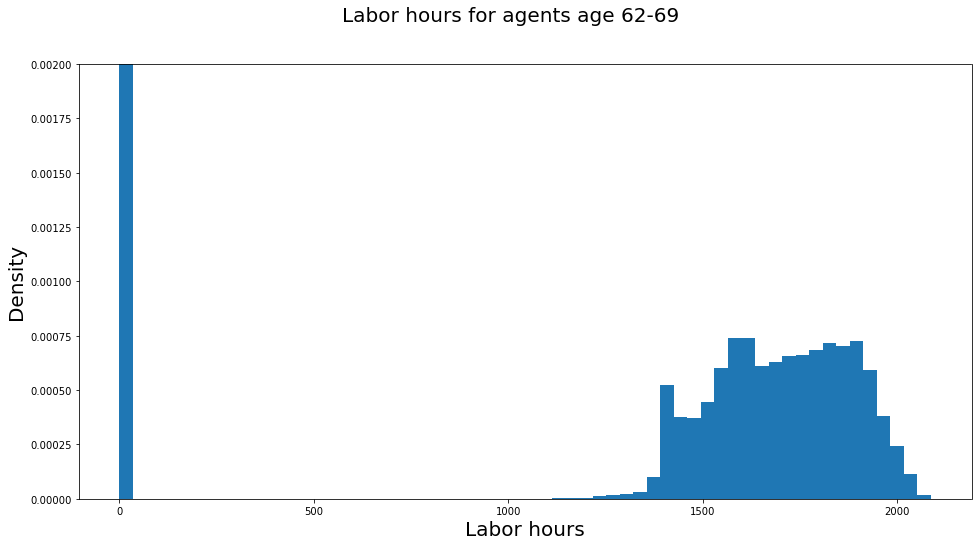

In [343]:
fig, axs = plt.subplots(figsize=(16,8))
n_bins = 60
density_labor=polL[13:19,:,:,1:10,:,:].reshape((6*30*10*9*2*5))
axs.hist(density_labor,density=True,bins=n_bins)
axs.set_ylim([0, 0.002])
axs.set_xlabel('Labor hours',fontsize=20)
axs.set_ylabel('Density',fontsize=20)
fig.suptitle('Labor hours for agents age 62-69', fontsize=20)
#fig.savefig('/Users/yanzhao/Desktop/labor_supply.png')


Text(0.5, 0.98, 'Initial Wage Distribution(age 50)')

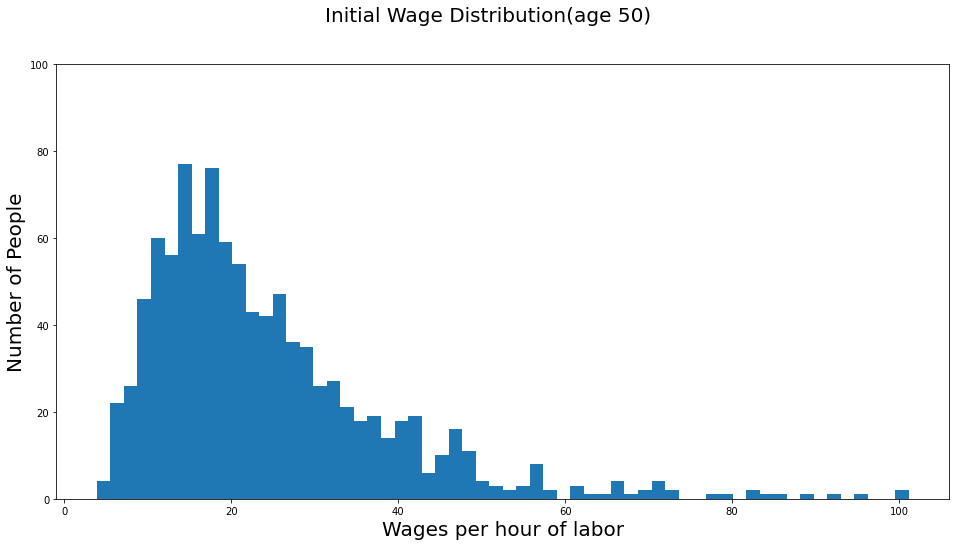

In [244]:
"""""""""""""""""""""""""""""""""""""""""""""
    Define the wage simulation function
"""""""""""""""""""""""""""""""""""""""""""""
#@nb.jit(nopython=True)
def simulate_wages(wages,N,σ,ρ,seed1):
    logw=np.zeros((T,N))
    η   =np.zeros((T,N))
    ϵ   =np.zeros((T,N))
    W   =np.zeros((T,N))
    detw=np.zeros((T,N))
    Σ=σ/(np.sqrt(1-ρ**2))
    detw=np.log(wages)
    
    @nb.jit(nopython=True)
    def trunc(value,miny,maxy):
        if value<miny:
            value=miny
        elif value>maxy:
            value=maxy
        else:
            pass
        return value
    
    np.random.seed(seed1)
    ϵ     =np.random.normal(0,σ,(T,N))
    η[0,:]=np.random.normal(0, Σ, (N,1)).flatten()
    for i in range(N):
        η[0,i]=trunc(η[0,i],-3*Σ,3*Σ)
        logw[0,i]=detw[0]+η[0,i]
        W[0,i]=np.exp(logw[0,i])
        for t in range(T-1):
            η[t+1,i]   =  0+ρ*(η[t, i] - 0) + trunc(ϵ[t+1, i], -3*σ, 3*σ)
            η[t+1,i]   =  trunc(η[t+1,i],-3*Σ,3*Σ)
            logw[t+1,i]=  detw[t+1] + η[t+1, i]
            W[t+1, i]  =  np.exp(logw[t+1,i])
    return logw, W,η,ϵ

logwMen, WW, η, ϵMen = simulate_wages(wages,1000,σ,ρ, 42)
fig, axs = plt.subplots(figsize=(16,8))
n_bins = 60
density_labor=polL[1,:,:,1:10,0,:].reshape((1*30*9*10*5))
axs.hist(WW[0,:],density=False,bins=n_bins)
axs.set_ylim([0, 100])
axs.set_xlabel('Wages per hour of labor',fontsize=20)
axs.set_ylabel('Number of People',fontsize=20)
fig.suptitle('Initial Wage Distribution(age 50)', fontsize=20)
#fig.savefig('/Users/yanzhao/Desktop/labor_supply.png')

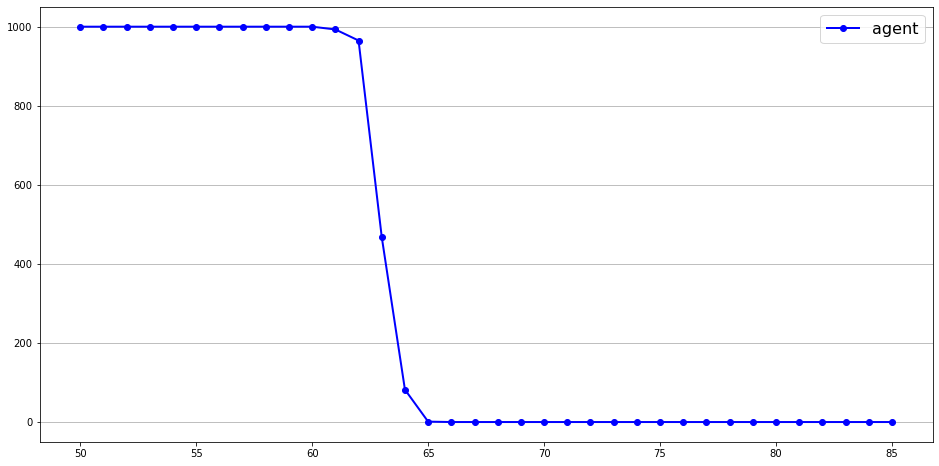

Text(0.5, 0.98, 'Civilian labor force participation rate, 55 and over(1948-2019)')

In [261]:
"""""""""""""""""""""""""""""""""""""""""""""
                Simulation
         Simulate 1000 individuals
"""""""""""""""""""""""""""""""""""""""""""""

N=1000
btGrid=np.array([0,1])
sim_C=np.zeros((T+1,N))
sim_L=np.zeros((T+1,N))
sim_B=np.zeros((T+1,N))
sim_Pwithdraw=np.zeros((T+1,N))

sim_A=np.zeros((T+1,N))
sim_AIME=np.zeros((T+1,N))
sim_Pen=np.zeros((T+1,N))
sim_bt=np.zeros((T+1,N))

aDist=np.random.normal(1e4,100,N)
aimeDist=np.random.normal(AIMEmean,AIMEsd/10,N)
penDist=np.random.normal(5e4,100,N)
grid2=UCGrid(aGrid,aimeGrid,penGrid,btGrid,epsGrid)

for i in range(N):
    sim_A[0,i]=aDist[i]
    sim_AIME[0,i]=aimeDist[i]
    sim_Pen[0,i]=penDist[i]
    for t in range(T):
        age=50+t
        point_2=np.array([sim_A[t,i],sim_AIME[t,i],sim_Pen[t,i],sim_bt[t,i],np.exp(η[t,i])])
        sim_A[t+1,i]=eval_linear(grid2,polA[t,:,:,:,:,:],point_2)
        sim_L[t,i]=eval_linear(grid2,polL[t,:,:,:,:,:],point_2)
        sim_L[t,i]=max(0,sim_L[t,i])
        sim_Pwithdraw[t,i]=eval_linear(grid2,polP[t,:,:,:,:,:],point_2)
        sim_Pen[t+1,i]=(1+r_pen)*(sim_Pen[t,i]+ϕ_1*WW[t,i]*sim_L[t,i]-sim_Pwithdraw[t,i])
        #(1+r_pen)*(pension+ϕ_1*w*h-pen_withdraw)
                        
        sim_C[t,i]=eval_linear(grid2,polC[t,:,:,:,:,:],point_2)
        sim_B[t,i]=eval_linear(grid2,polB[t,:,:,:,:,:],point_2)
        
        if sim_B[t,i]>0.5:
            sim_B[t,i]=1
            sim_L[t,i]=0
        else:
            sim_B[t,i]=0
        sim_bt[t,i] = sim_B[t,i]
        
        #eretadj = np.array([(5/9)*0.01*36, (5/9)*0.01*24, (5/9)*0.01*12])
        #litcred = np.array([0.06, 0.12, 0.18, 0.24,0.30])
        #early=array([0.92307692, 0.92857143, 0.93333333])
        #late=array([0.06, 0.05660377, 0.05357143, 0.05084746, 0.0483871 ])

        if age==62 and sim_B[t,i]==1:
            nextPIA=computePIA(sim_AIME[t,i])*(early[0])
            sim_AIME[t+1,i]=findAIME(nextPIA)
        elif age==63 and sim_B[t,i]==1:
            nextPIA=computePIA(sim_AIME[t,i])*(early[1])
            sim_AIME[t+1,i]=findAIME(nextPIA)
        elif age==64 and sim_B[t,i]==1:
            nextPIA=computePIA(sim_AIME[t,i])*(early[2])
            sim_AIME[t+1,i]=findAIME(nextPIA)
        elif age==65 and sim_B[t,i]==0:
            aimee=computeAIME(sim_AIME[t,i],WW[t,i]*sim_L[t,i],age)
            nextPIA=computePIA(aimee)*(1+late[0])
            sim_AIME[t+1,i]=findAIME(nextPIA)
        elif age==66 and sim_B[t,i]==0:
            aimee=computeAIME(sim_AIME[t,i],WW[t,i]*sim_L[t,i],age)
            nextPIA=computePIA(aimee)*(1+late[1])
            sim_AIME[t+1,i]=findAIME(nextPIA)
        elif age==67 and sim_B[t,i]==0:
            aimee=computeAIME(sim_AIME[t,i],WW[t,i]*sim_L[t,i],age)
            nextPIA=computePIA(aimee)*(1+late[2])
            sim_AIME[t+1,i]=findAIME(nextPIA)
        elif age==68 and sim_B[t,i]==0:
            aimee=computeAIME(sim_AIME[t,i],WW[t,i]*sim_L[t,i],age)
            nextPIA=computePIA(aimee)*(1+late[3])
            sim_AIME[t+1,i]=findAIME(nextPIA)
        elif age==69 and sim_B[t,i]==0:
            aimee=computeAIME(sim_AIME[t,i],WW[t,i]*sim_L[t,i],age)
            nextPIA=computePIA(aimee)*(1+late[4])
            sim_AIME[t+1,i]=findAIME(nextPIA)
        else:
            sim_AIME[t+1,i]=computeAIME(sim_AIME[t,i],WW[t,i]*sim_L[t,i],age)

            

age_x=np.arange(T)
age_x=50+age_x
ave_labor_hours=np.zeros(T)

for age in range(T):
    ave_labor_hours[age]= np.count_nonzero(sim_L[age,:]>0) 


tick_spacing = 5
fig, ax = plt.subplots(figsize=(16,8))
ax.plot( age_x,ave_labor_hours, 'b-',linewidth=2,marker='o',label='agent')
#ax.plot(data2["Year"],data2["Total"], 'm-', linewidth=2,label='Total')
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
#ax.set_xlim(1, 2)
#ax.set_ylim(0.3, 1.1)
ax.yaxis.grid(linestyle='-')
ax.legend(loc=0,prop={'size':16})

plt.show()
fig.suptitle('Civilian labor force participation rate, 55 and over(1948-2019)', fontsize=20)
#fig.savefig('55_and_over(male and female).png')


In [ ]:
for i in range(500):
    print('---------------------------')
    print(sim_L[:,i])
    print('---------------------------')

In [ ]:
print(sim_L[14,:])

In [254]:
np.count_nonzero( sim_Pwithdraw[10,:]>10)

445

In [220]:
np.amax(sim_Pen)

411990.9938039071

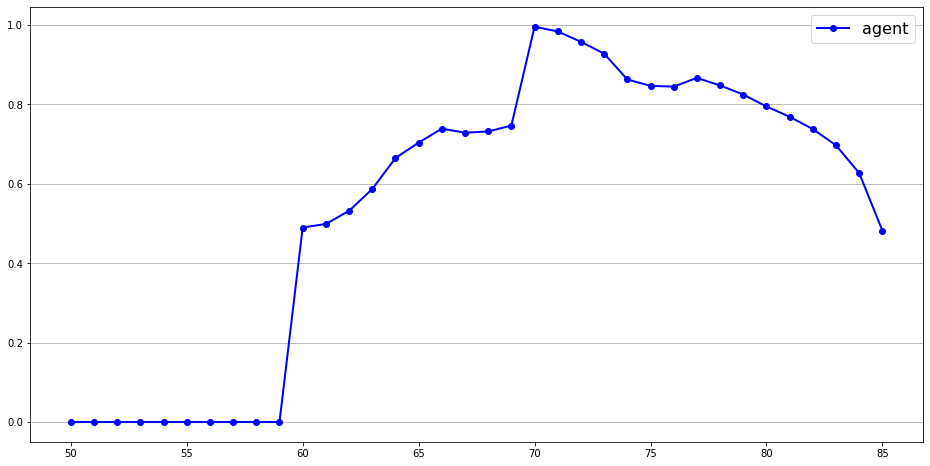

Text(0.5, 0.98, 'Civilian labor force participation rate, 55 and over(1948-2019)')

In [263]:
age_x=np.arange(T)
age_x=50+age_x
withdraw_num=np.zeros(T)
lfp=np.zeros(T)

for age in range(T):
    withdraw_num[age]=np.count_nonzero(sim_Pwithdraw[age,:]>100) 
    lfp[age]= withdraw_num[age]/1000


tick_spacing = 5
fig, ax = plt.subplots(figsize=(16,8))
ax.plot( age_x,lfp, 'b-',linewidth=2,marker='o',label='agent')
#ax.plot(data2["Year"],data2["Total"], 'm-', linewidth=2,label='Total')
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
#ax.set_xlim(1, 2)
#ax.set_ylim(0.3, 1.1)
ax.yaxis.grid(linestyle='-')
ax.legend(loc=0,prop={'size':16})

plt.show()
fig.suptitle('Civilian labor force participation rate, 55 and over(1948-2019)', fontsize=20)
#fig.savefig('55_and_over(male and female).png')


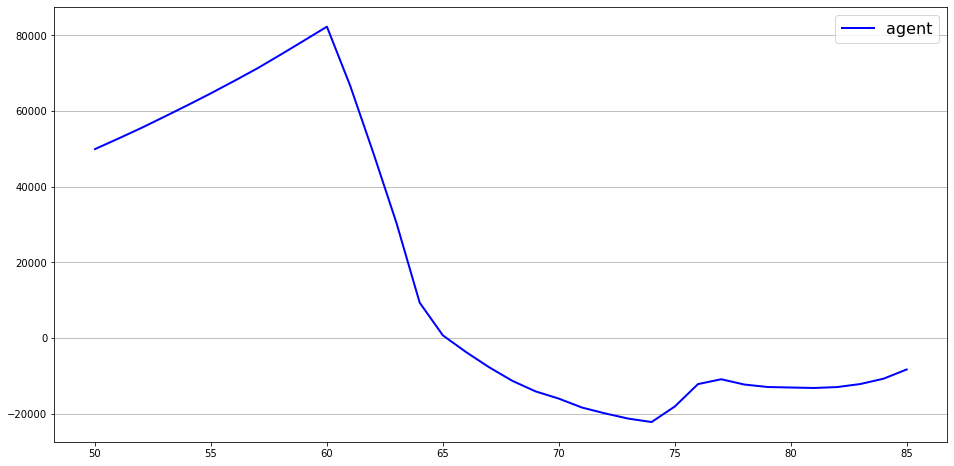

Text(0.5, 0.98, 'Civilian labor force participation rate, 55 and over(1948-2019)')

In [297]:
age_x=np.arange(T)
age_x=50+age_x
withdraw_num=np.zeros(T)
lfp=np.zeros(T)

for age in range(T):
    withdraw_num[age]=np.count_nonzero(sim_Pwithdraw[age,:]>0) 
    lfp[age]= withdraw_num[age]/1000


tick_spacing = 5
fig, ax = plt.subplots(figsize=(16,8))
ax.plot( age_x,sim_Pen[0:36,445], 'b-',linewidth=2,label='agent')
#ax.plot(data2["Year"],data2["Total"], 'm-', linewidth=2,label='Total')
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
#ax.set_xlim(1, 2)
#ax.set_ylim(0.3, 1.1)
ax.yaxis.grid(linestyle='-')
ax.legend(loc=0,prop={'size':16})

plt.show()
fig.suptitle('Civilian labor force participation rate, 55 and over(1948-2019)', fontsize=20)
#fig.savefig('55_and_over(male and female).png')


Text(0.5, 0.98, 'Labor hours for agents age 62-69')

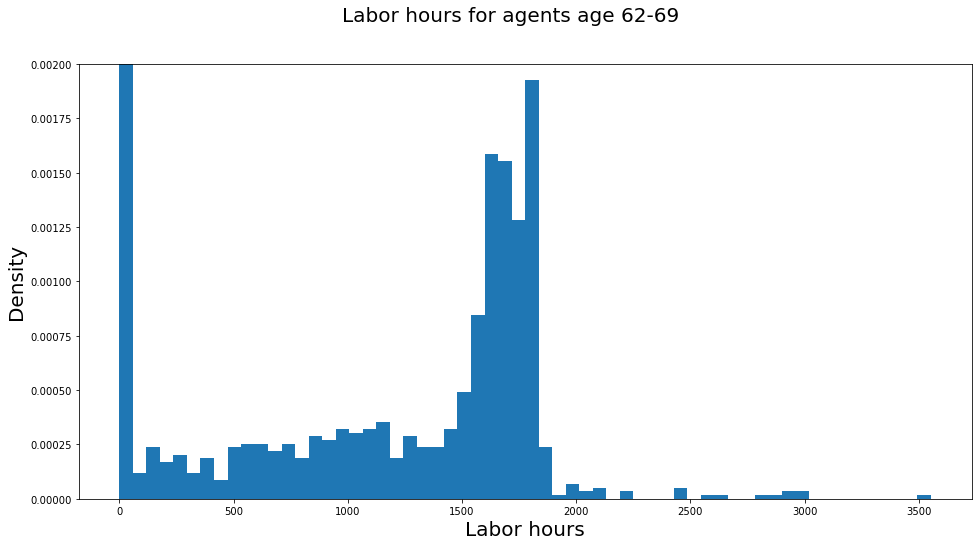

In [336]:
fig, axs = plt.subplots(figsize=(16,8))
n_bins = 60
density_labor=sim_L[12,:].reshape(((1)*N))
axs.hist(density_labor,density=True,bins=n_bins)
axs.set_ylim([0, 0.002])
axs.set_xlabel('Labor hours',fontsize=20)
axs.set_ylabel('Density',fontsize=20)
fig.suptitle('Labor hours for agents age 62-69', fontsize=20)
#fig.savefig('/Users/yanzhao/Desktop/labor_supply.png')

In [342]:
np.count_nonzero(sim_Pen[35,:]<0) 

518